In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import cv2
from tensorflow.keras.layers import Flatten, Dense, Activation
import matplotlib.pyplot as plt
from scipy.integrate import simps
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import visualkeras
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from PIL import Image
import pickle


2024-10-06 16:44:13.826857: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 16:44:13.826974: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 16:44:13.829085: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 16:44:14.045089: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## extracting_images , Data preprocessing and augmentation

In [5]:
dataset_dir=r"/home/gourav/Desktop/vss/capstone/dataset/train"
classes=['eyes-close','eyes-open']
input_shape = (224, 224, 3)
num_classes = 1
batch_size = 32
epochs = 650


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb', 
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    subset='validation'
)

Found 25015 images belonging to 2 classes.
Found 6253 images belonging to 2 classes.


## visualization of images

(array([[[[0.19607845, 0.19607845, 0.19607845],
         [0.19607845, 0.19607845, 0.19607845],
         [0.19719599, 0.19719599, 0.19719599],
         ...,
         [0.3497519 , 0.3497519 , 0.3497519 ],
         [0.35061967, 0.35061967, 0.35061967],
         [0.35148746, 0.35148746, 0.35148746]],

        [[0.19543597, 0.19543597, 0.19543597],
         [0.19745304, 0.19745304, 0.19745304],
         [0.19875468, 0.19875468, 0.19875468],
         ...,
         [0.3529412 , 0.3529412 , 0.3529412 ],
         [0.3529412 , 0.3529412 , 0.3529412 ],
         [0.3529412 , 0.3529412 , 0.3529412 ]],

        [[0.20365575, 0.20365575, 0.20365575],
         [0.2076228 , 0.2076228 , 0.2076228 ],
         [0.20784315, 0.20784315, 0.20784315],
         ...,
         [0.3529412 , 0.3529412 , 0.3529412 ],
         [0.3529412 , 0.3529412 , 0.3529412 ],
         [0.3529412 , 0.3529412 , 0.3529412 ]],

        ...,

        [[0.24705884, 0.24705884, 0.24705884],
         [0.24705884, 0.24705884, 0.24705884

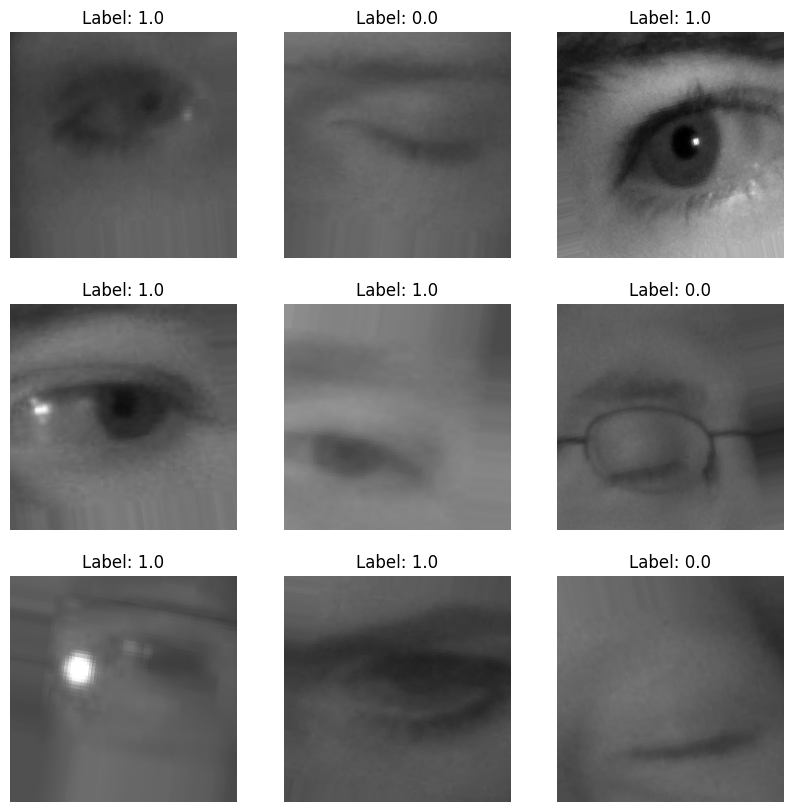

In [6]:
batch = next(train_generator)
images = batch[0] 
labels = batch[1] 

# Plot the images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i], cmap='gray') 
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")
plt.show()


## model

In [8]:

base_model = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')

# for layer in base_model.layers[:-10]:
#     layer.trainable = False

base_input = base_model.input
base_output = base_model.layers[-1].output  
# base output is output tensor which means what is output shape that means what input shape is getting gin 2d layer ......... outpput of base output
x = GlobalAveragePooling2D()(base_output)  
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x) 
final_output = Dense(num_classes)(x) 

final_model = Model(inputs=base_input, outputs=final_output)

## compiling model- Model: "mobilenet_1.00_224"

In [17]:
final_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()])

final_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [2]:
import tensorflow as tf

def check_cuda_tensorflow():
    # Check TensorFlow version
    print("TensorFlow version:", tf.__version__)
    
    # Check if TensorFlow can access GPU
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        
        print("TensorFlow is using the following GPU(s):")
        for gpu in gpus:
            print(f" - {gpu}")
        
        # Optional: Print CUDA device properties
        for gpu in gpus:
            details = tf.config.experimental.get_device_details(gpu)
            print(details)
    else:
        print("No GPU available. TensorFlow is using the CPU.")

# Run the check
check_cuda_tensorflow()


TensorFlow version: 2.14.0
TensorFlow is using the following GPU(s):
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
{'compute_capability': (8, 6), 'device_name': 'NVIDIA GeForce RTX 3060 Laptop GPU'}


2024-08-27 23:49:14.795752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-27 23:49:14.828979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-27 23:49:14.829333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Training

In [19]:


history = final_model.fit(
    train_generator,
    steps_per_epoch=200,
    epochs=epochs,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=100,
    )

Epoch 1/650


2024-05-25 08:54:34.794028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-05-25 08:54:37.975659: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x726698357bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-25 08:54:37.975698: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-25 08:54:37.982550: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-25 08:54:38.077660: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - 77s 314ms/step - loss: 5.9744 - binary_accuracy: 0.9266 - precision_1: 0.9705 - recall_1: 0.9076 - auc_1: 0.9507 - val_loss: 4.9265 - val_binary_accuracy: 0.9400 - val_precision_1: 0.9973 - val_recall_1: 0.9071 - val_auc_1: 0.9687
Epoch 2/650
200/200 [==============================] - 63s 315ms/step - loss: 4.0765 - binary_accuracy: 0.9711 - precision_1: 0.9824 - recall_1: 0.9714 - auc_1: 0.9768 - val_loss: 3.4697 - val_binary_accuracy: 0.8859 - val_precision_1: 0.9994 - val_recall_1: 0.8175 - val_auc_1: 0.9319
Epoch 3/650
200/200 [==============================] - 62s 312ms/step - loss: 2.8032 - binary_accuracy: 0.9777 - precision_1: 0.9850 - recall_1: 0.9788 - auc_1: 0.9807 - val_loss: 2.3195 - val_binary_accuracy: 0.9784 - val_precision_1: 0.9943 - val_recall_1: 0.9706 - val_auc_1: 0.9857
Epoch 4/650
200/200 [==============================] - 65s 324ms/step - loss: 1.9625 - binary_accuracy: 0.9797 - precision_1: 0.9861 - recall_1: 0.9805 - 

In [20]:
with open('/home/gourav/Desktop/vss/capstone/history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [21]:
final_model.save('best_driver.h5')

/home/gourav/anaconda3/envs/gpu2/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
   
model = keras.models.load_model('/home/gourav/Desktop/vss/capstone/best_model.h5')
model.save('/home/gourav/Desktop/vss/capstone/best_model_mobile')

2024-06-18 15:46:51.265945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-18 15:46:51.273127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-18 15:46:51.273489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

INFO:tensorflow:Assets written to: /home/gourav/Desktop/vss/capstone/best_model_mobile/assets


INFO:tensorflow:Assets written to: /home/gourav/Desktop/vss/capstone/best_model_mobile/assets


## Testing 

In [6]:

    
model = keras.models.load_model('/home/gourav/Desktop/vss/capstone/best_model.h5')
compiled_metrics = model.metrics

test_data_generator = ImageDataGenerator(rescale=1.0/255.0)  

test_generator = test_data_generator.flow_from_directory(
    '/home/gourav/Desktop/vss/capstone/dataset/test',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False 
)

result = model.evaluate(test_generator)

print("Test Loss:", result[0])
print("Test Accuracy:", result[1])
print("Test Accuracy:", result[1]*100)

2024-08-26 13:28:39.693640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-26 13:28:39.699345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-26 13:28:39.699685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Found 1269 images belonging to 2 classes.


2024-08-26 13:28:41.244624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


40/40 [==============================] - 5s 65ms/step - loss: 0.0798 - binary_accuracy: 0.9827 - precision_1: 0.9767 - recall_1: 0.9890 - auc_1: 0.9826
Test Loss: 0.07977848500013351
Test Accuracy: 0.9826635122299194
Test Accuracy: 98.26635122299194


 ## Plotting training and validation loss over epochs

In [2]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss Over Epochs')
plt.ylabel('Loss Value')
plt.xlabel('Number of Epochs')
plt.legend(loc="upper left")
plt.savefig('Training-Validation_loss_v1_softplus_100_layer_4_original_data.png')
plt.show()


NameError: name 'history' is not defined

## accuracy

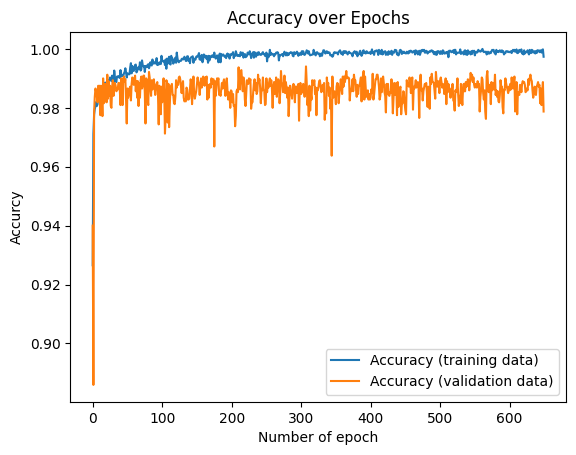

In [27]:
plt.plot(history.history['binary_accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_binary_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy over Epochs')
plt.ylabel('Accurcy')
plt.xlabel('Number of epoch')
plt.legend(loc="lower right")
plt.show()


## Confusion Matrix

40/40 [==============================] - 3s 64ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       633
           1       0.98      0.99      0.98       636

    accuracy                           0.98      1269
   macro avg       0.98      0.98      0.98      1269
weighted avg       0.98      0.98      0.98      1269


Confusion Matrix:
[[618  15]
 [  7 629]]


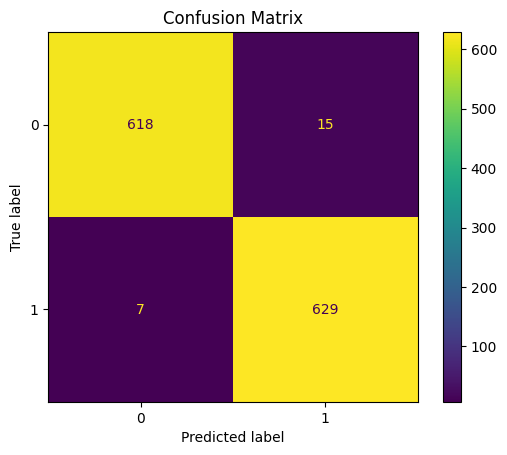

In [7]:
# Predictions
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype('int32').flatten()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plotting Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Confusion Matrix')
plt.show()



In [8]:
# Detailed Accuracy Metrics
print("\nDetailed Accuracy Metrics:")
report = classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys()), output_dict=True)
for label, metrics in report.items():
    if isinstance(metrics, dict):
        print(f"Class '{label}' - Precision: {metrics['precision']:.2f}, Recall: {metrics['recall']:.2f}, F1-Score: {metrics['f1-score']:.2f}")


Detailed Accuracy Metrics:
Class 'eyes-close' - Precision: 0.99, Recall: 0.98, F1-Score: 0.98
Class 'eyes-open' - Precision: 0.98, Recall: 0.99, F1-Score: 0.98
Class 'macro avg' - Precision: 0.98, Recall: 0.98, F1-Score: 0.98
Class 'weighted avg' - Precision: 0.98, Recall: 0.98, F1-Score: 0.98
